# Week 7. Convolutional Neural Networks: an Introduction

This notebook is heavily inspired by Andre Guernon work, that can be found here: https://github.com/ageron/handson-ml2/blob/master/14_deep_computer_vision_with_cnns.ipynb. Check it out!

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
## Install dependencies
import tensorflow as tf
from tensorflow import keras
print('Tensorflow version', tf.__version__)
print('Keras version', keras.__version__)

Tensorflow version 2.1.0
Keras version 2.2.4-tf


## 1. A quick overview on Convolutions

In [3]:
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

Now we can print out our images and see how they look like:

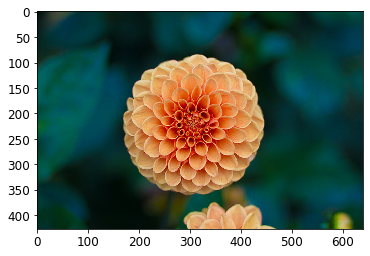

In [4]:
plt.imshow(flower)

In [5]:
# Create 2 7x7 filters, the first one as a vertical line the second one as a h
filters = np.zeros(shape=(7, 7, channels, 3), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

edge_filter = -1.0*np.ones((7, 7))
edge_filter[3, 3] = 48
edge_filter = np.repeat(edge_filter[:, :, np.newaxis], 3, axis=2)
edge_filter = tf.constant(edge_filter, shape=(7, 7, channels), dtype=tf.float32)
filters[:, :, :, 2] = edge_filter  # horizontal line


Now we can print out our filters and see how they look like:

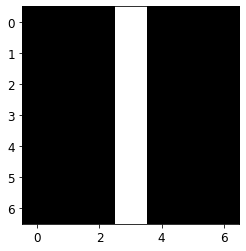

In [6]:
plt.imshow(filters[:, :, 0, 0], cmap='gray')

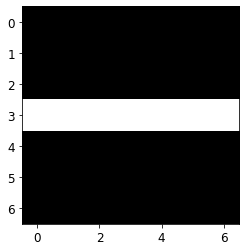

In [7]:
plt.imshow(filters[:, :, 0, 1], cmap='gray')

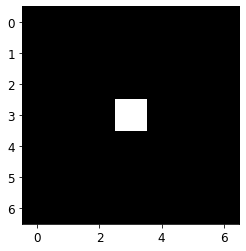

In [8]:
plt.imshow(filters[:, :, 0, 2], cmap='gray')

Now, let's perform the convolution:

In [9]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME") # usinge zero padding otherwise 'valid'

In [10]:
# A couple of functions to plot greyscale and colour images
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# crop images
def crop(images):
    return images[150:220, 130:250]

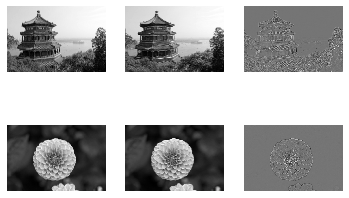

In [11]:
for image_index in (0, 1):
    for feature_map_index in (0, 1, 2):
        plt.subplot(2, 3, image_index * 3 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

### Filter 1: Vertical line detection

See this detail of the Chinese temple picture

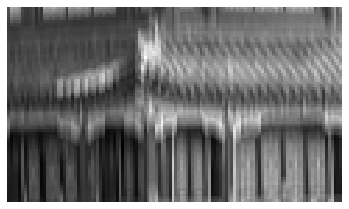

In [12]:
plot_image(crop(outputs[0, :, :, 0]))

### Filter 2: Horizontal line detection

See this detail of the Chinese temple picture

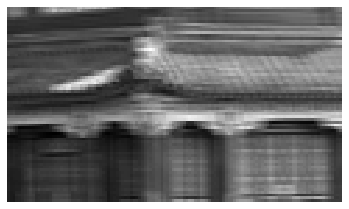

In [13]:
plot_image(crop(outputs[0, :, :, 1]))

### Filter 3:Edge detection

This is very analogous to the behaviour of some cells in the Primary Visual Area of the Primates Brain (area V1).

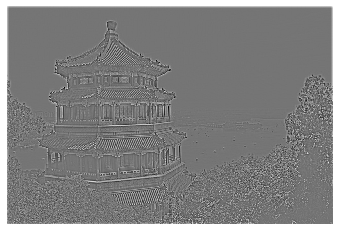

In [14]:
plot_image(outputs[0, :, :, 2])

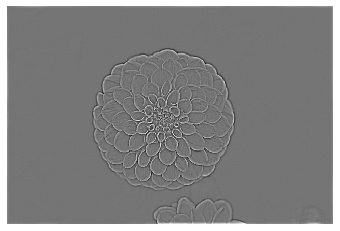

In [15]:
plot_image(outputs[1, :, :, 2])

## 2. Convolutional and pooling layers in Keras

### 2.1 Convolutional Layer

In [16]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")
conv

### 2.2 Pooling Layer

In [17]:
max_pool = keras.layers.MaxPool2D(pool_size=2)
max_pool

## 3. A Convolutional Network for the Fashion MNIST dataset (image classification)

In [18]:
### Load the data; create training, test and validation sets
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

**Exercise 01:** Let us implement a simple CNN to tackle the Fashion MNIST dataset. We will implement a CNN with these requirements:
  * a first 2-D Convolutional layer with 64 7x7 kernel filters, ReLU activation, and zero padding. Remember that the imput shape must be of the size of a single frame of the input image  
  * a max-pooling layer with pool size of 2
  * a second 2-D Convolutional layer with 128 3x3 kernel, ReLU activation, and zero padding.
  * a third 2-D Convolutional layer with 128 3x3 kernel, ReLU activation, and zero padding.
  * a max-pooling layer with pool size of 2
  * Now we repeat the same structure again: two more 2-D Convolutional layers with 256 3x3 kernel, ReLU activation, and zero padding, followed by one more MaxPooling layer with pool size of 2
  * After that, stack a fully connected network, composed of two hidden dense layers and a dense output layer. you must flatten the inputs to the first dense layer, since a dense network expects a 1D array of features for each instance. Furthermore, add two dropout layers to the Dense hidden layers, with a dropout rate of 50% each, to reduce overfitting. The first dense layer will have 128 neurons, the second hidden layer will have 64.

The number of kernel filters grows as we go up in the CNN towards the output layer: it is initially 64, then 128, then 256. It makes sense to have it increasing: the number of low-level visual feature is generally fairly low (e.g., edges, small circles...), but there are various ways to use them to generate higher-level features. Doubling the number of filters after each pooling layer is a common practice. A pooling layer divides each spatial dimension by a factor of 2, so we can afford to double the number of feature maps in the next layer without parameter explosion and increase of memory usage.

In [19]:
from tensorflow import keras

In [20]:
# to speed up learning rate increase stride

# Write your solution here:
n_net = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=7, strides=1, padding="SAME", input_shape=[28,28,1], activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="SAME", activation="relu"),
    keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding="SAME", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="SAME", activation="relu"),
    keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="SAME", activation="relu"),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),        
    keras.layers.Dense(10, activation="softmax")
]
)

In [21]:
n_net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 256)         5

**Exercise 02:** Now let's compile and train the model. Use the correct loss function, the NADAM optimizer, and "accuracy" as a metric. Train the network ideally for at least 10 epochs.
If the model takes too much to compile you can consider increasing the stride, or reducing the number of filters. This will likely affect your accuracy. On my 2019 MacBookPro each epoch takes about 6 minutes to complete, so expect a full training session of 10 epochs to last 1 hour or more. Once you have successfully trained your model you can save it for later usage/deployment

In [22]:
# compile your model here:
n_net.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Nadam(), # aka 'nadam'
              metrics=["accuracy"])

In [23]:
# train your model here and return the history object:
history = n_net.fit(X_train, y_train, epochs=10, validation_data=[X_valid, y_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 687s 12ms/sample - loss: 0.7199 - accuracy: 0.7491 - val_loss: 0.4168 - val_accuracy: 0.8586
Epoch 2/10
55000/55000 [==============================] - 728s 13ms/sample - loss: 0.4321 - accuracy: 0.8568 - val_loss: 0.3314 - val_accuracy: 0.8816
Epoch 3/10
55000/55000 [==============================] - 752s 14ms/sample - loss: 0.3696 - accuracy: 0.8761 - val_loss: 0.3364 - val_accuracy: 0.8752
Epoch 4/10
55000/55000 [==============================] - 799s 15ms/sample - loss: 0.3348 - accuracy: 0.8873 - val_loss: 0.2791 - val_accuracy: 0.8936
Epoch 5/10
55000/55000 [==============================] - 797s 14ms/sample - loss: 0.3113 - accuracy: 0.8969 - val_loss: 0.2907 - val_accuracy: 0.8930
Epoch 6/10
55000/55000 [==============================] - 704s 13ms/sample - loss: 0.2915 - accuracy: 0.9011 - val_loss: 0.2975 - val_accuracy: 0.8984
Epoch 7/10
55000/55000 [=====================

Finally we can evaluate the performance on the test set, if we are happy with the training result.

In [24]:
score = n_net.evaluate(X_test, y_test, verbose=0)

In [25]:
X_new = X_test[:10] # pretend we have new images, let's try and have a few predictions
y_pred = n_net.predict(X_new)

In [26]:
y_pred

array([[1.66628108e-27, 0.00000000e+00, 4.26715247e-36, 0.00000000e+00,
        0.00000000e+00, 1.31626576e-11, 5.44902170e-33, 7.54756172e-07,
        2.29777499e-33, 9.99999285e-01],
       [7.25182531e-07, 9.49205873e-16, 9.80761349e-01, 6.84433488e-09,
        8.26057047e-03, 2.12373473e-22, 1.09773763e-02, 1.27671193e-22,
        3.27077983e-11, 5.34111103e-20],
       [3.34771032e-19, 1.00000000e+00, 2.08656819e-35, 4.07849658e-28,
        1.85875967e-26, 0.00000000e+00, 3.55064396e-28, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.93209059e-17, 1.00000000e+00, 1.19383771e-31, 3.01597617e-23,
        3.10660177e-23, 0.00000000e+00, 4.73121793e-25, 0.00000000e+00,
        5.72830293e-36, 0.00000000e+00],
       [2.20817495e-02, 2.74701478e-07, 1.00584123e-02, 9.05387511e-04,
        3.07169836e-02, 3.48418829e-11, 9.36235547e-01, 2.16856546e-12,
        1.68210545e-06, 3.11443198e-11],
       [2.51817881e-12, 1.00000000e+00, 1.86173673e-22, 8.45250373e-18,
   

**Exercise 2:** How can print out the predicted classes? Do it here:

In [27]:
# Write your solution here:
